In [32]:
# from google.colab import files
# uploaded = files.upload()

In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import re
import pickle
import numpy as np
import string


file_path = 'Amazon0302.txt'


df = pd.read_csv(file_path, sep='\t', skiprows=4, header=None, names=['Start_Node', 'End_Node'], nrows=1000) # Remove nrows before submitting to run on all data

G = nx.DiGraph()


for index, row in df.iterrows():
    G.add_edge(row['Start_Node'], row['End_Node'])


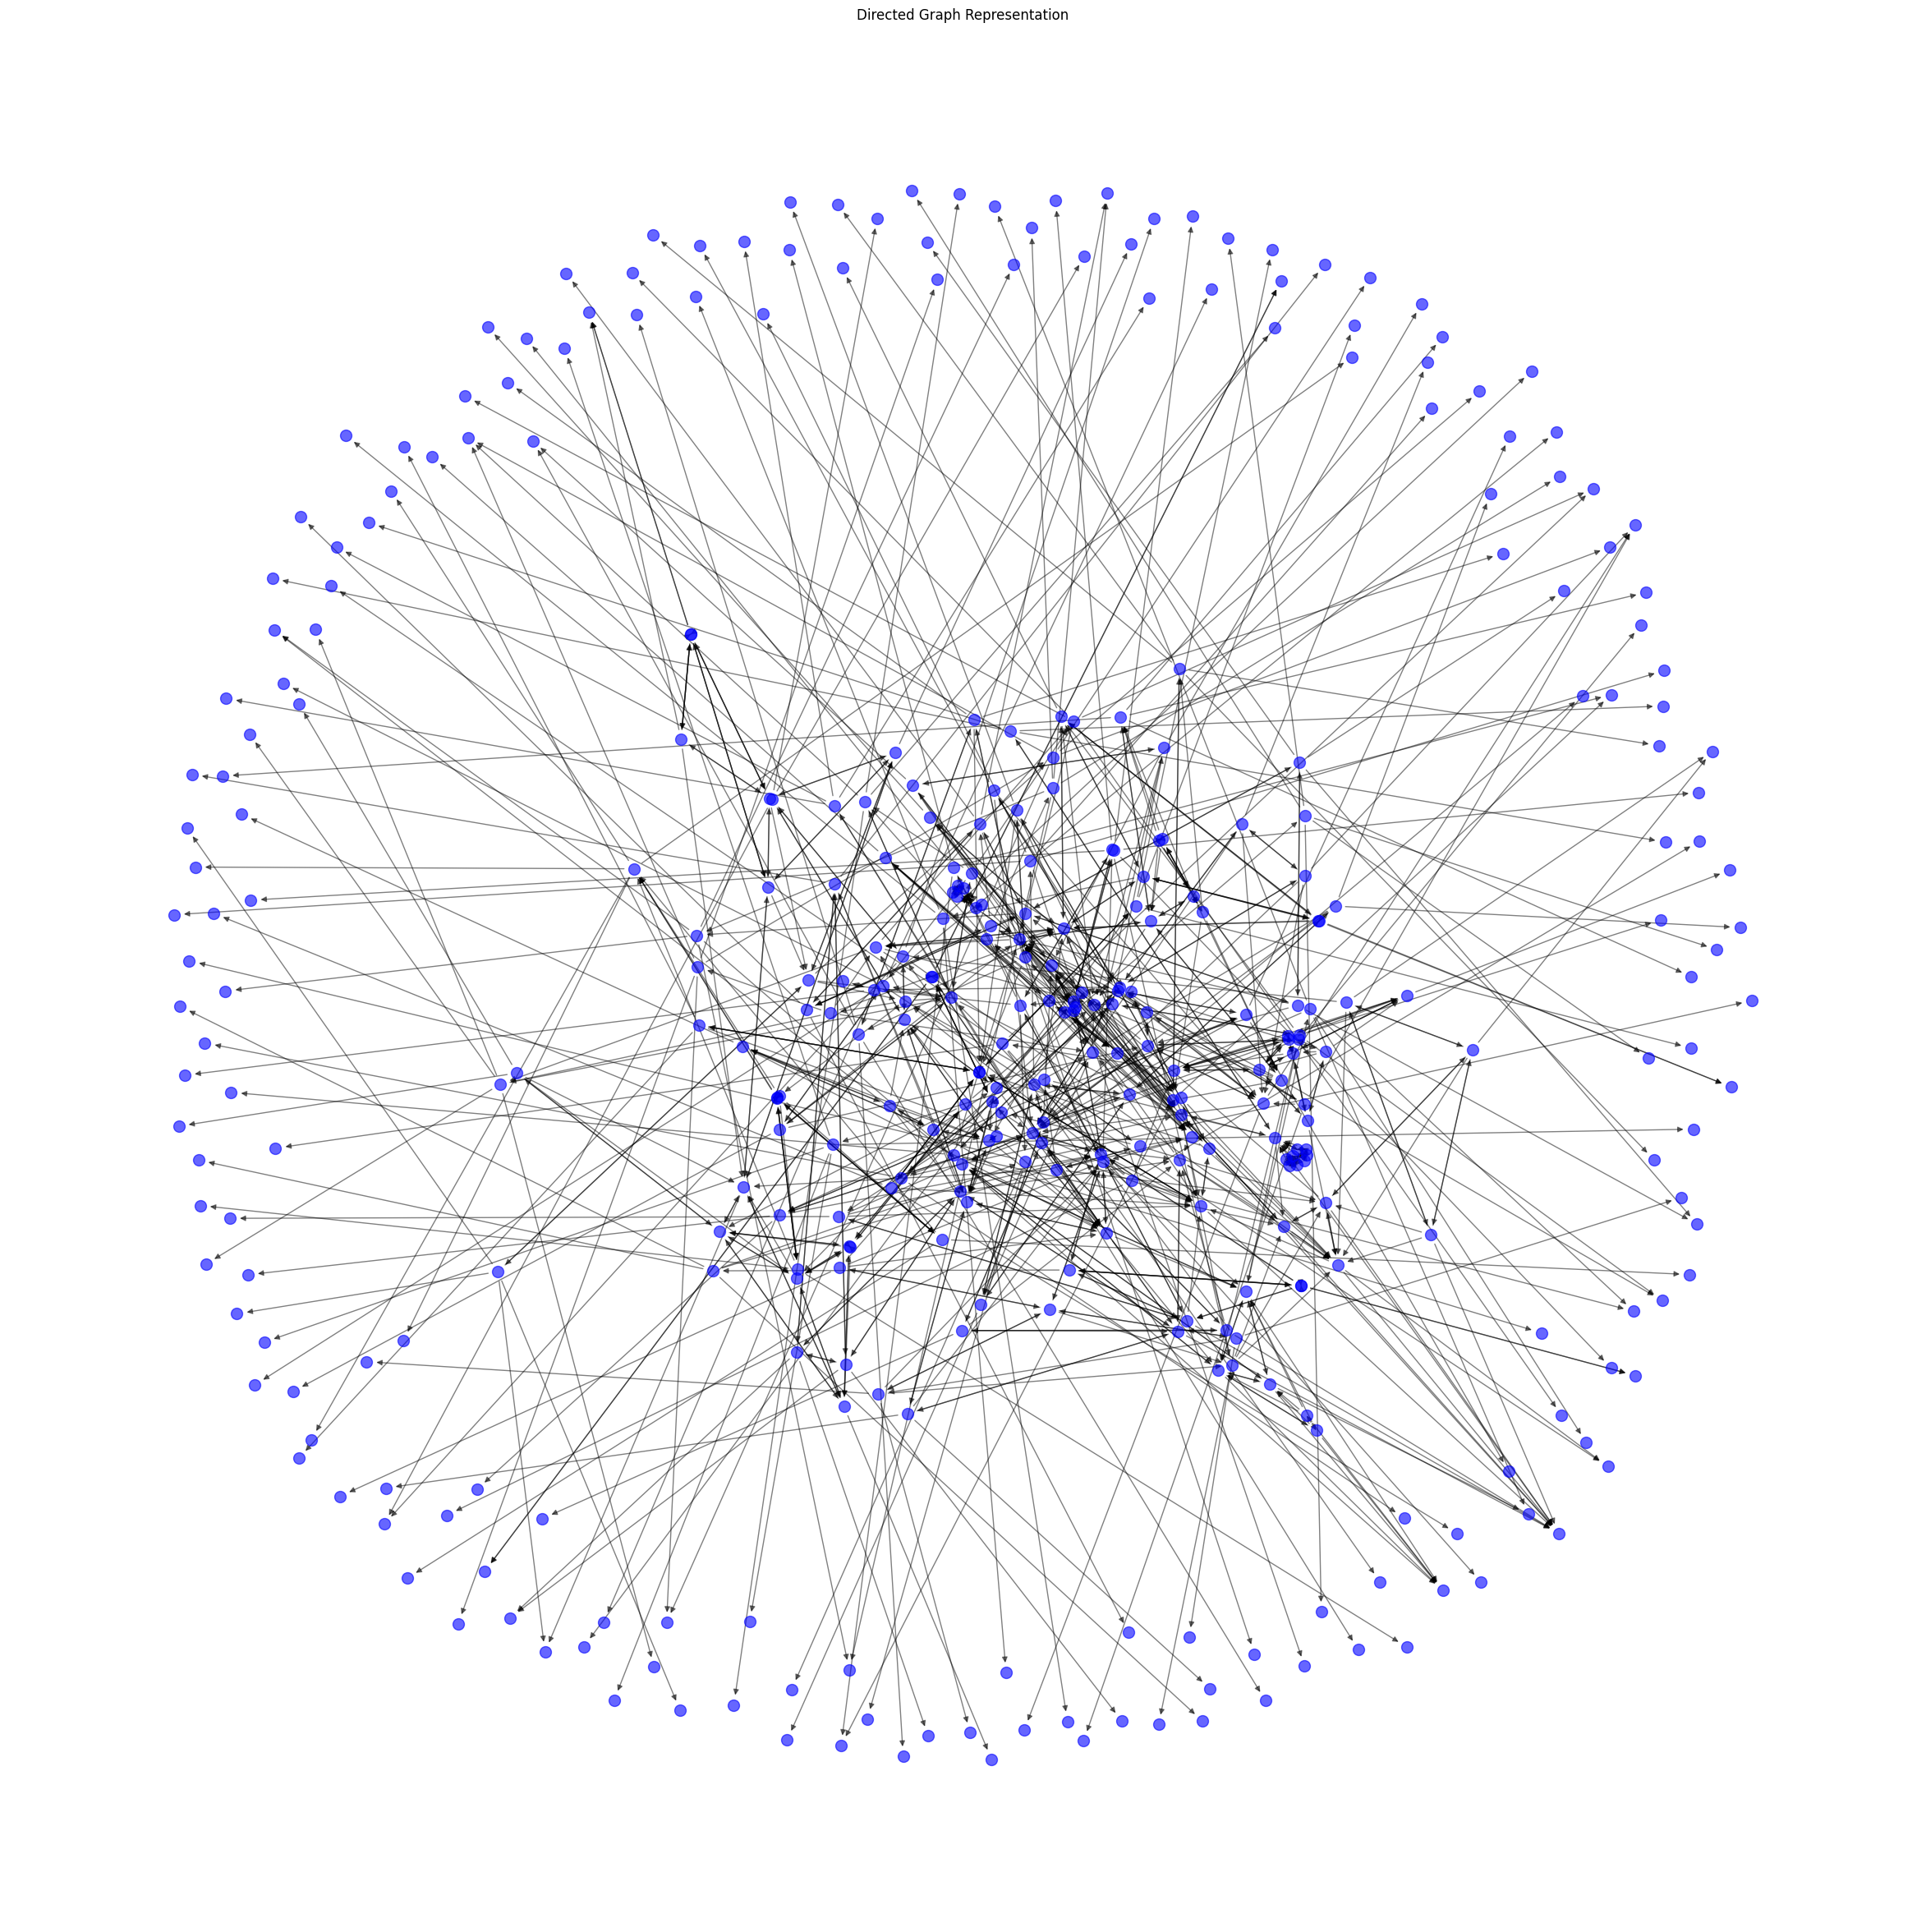

In [34]:
plt.figure(figsize=(30, 30))




pos = nx.spring_layout(G)

nx.draw_networkx_nodes(G, pos, node_size=100, node_color='blue', alpha=0.6)
nx.draw_networkx_edges(G, pos, width=1, alpha=0.5, arrowstyle='-|>', arrowsize=10)


plt.title('Directed Graph Representation')
plt.axis('off')
plt.show()

In [35]:
# Calculation of dataset statistics from : https://snap.stanford.edu/data/amazon0302.html


print("Number of nodes:", G.number_of_nodes())
print("Number of edges:", G.number_of_edges())


G_undirected = G.to_undirected()

# Find all weakly connected components, sorted by size
wccs = sorted(nx.connected_components(G_undirected), key=len, reverse=True)
sccs = sorted(nx.strongly_connected_components(G), key=len, reverse=True)

# Largest WCC
largest_wcc = wccs[0]
largest_scc = sccs[0]

# You can access the subgraph of the largest WCC like this
largest_wcc_subgraph = G.subgraph(largest_wcc)
largest_scc_subgraph = G.subgraph(largest_scc)

# Basic information about the largest WCC
print("Number of nodes in the largest WCC:", len(largest_wcc))
print("Number of edges in the largest WCC:", largest_wcc_subgraph.number_of_edges())
print("Number of nodes in the largest SCC:", len(largest_scc))
print("Number of edges in the largest SCC:", largest_scc_subgraph.number_of_edges())
print("Average Clustering Coeff:", nx.average_clustering(G))
print("Number of Triangles:", len(nx.triangles(G_undirected)))
print("Fraction of closed Triangles: ", nx.transitivity(G))
#print("Diameter (longest Shortest path):", nx.diameter(G_undirected))

Number of nodes: 389
Number of edges: 1000
Number of nodes in the largest WCC: 389
Number of edges in the largest WCC: 1000
Number of nodes in the largest SCC: 127
Number of edges in the largest SCC: 485
Average Clustering Coeff: 0.21458342220767315
Number of Triangles: 389
Fraction of closed Triangles:  0.33792585170340683


In [36]:
def clean_category_list(cat_list):
    cleaned_list = [item.split('[')[0].strip() for item in cat_list if '[' in item]
    return cleaned_list

In [37]:
fhr = open('amazon-meta.txt', 'r', encoding='utf-8', errors='ignore')

productList = []
count = 0
for line in fhr:
    
    line = line.strip()
    # a product block started
    if(line.startswith("Id")):
        Id = line[3:].strip()
    elif(line.startswith("ASIN")):
        ASIN = line[5:].strip()
    elif(line.startswith("group")):
        Group = line[6:].strip()
    elif(line.startswith("salesrank")):
        SalesRank = line[10:].strip()
    elif(line.startswith("similar")):
        Similar = line.strip().split()
        similarList=[]
        if(len(Similar)>2):
            for k in range(2,len(Similar),1):
                similarList.append(Similar[k])
    elif(line.startswith("categories")):
        ls = line.split()
        if(ls[1]!="0"):        
            Common_Categories = ' '.join((fhr.readline()).lower() for i in range(1))
            Common_Categories= Common_Categories.split("|")
            #print(Catagories)
        else:
            Common_Categories=""
    elif(line.startswith("reviews")):
        ls = line.split()
        TotalReviews = ls[2].strip()
        AvgRating = ls[7].strip()

    # a product block ended
    # write out fields to list
    elif (line==""):
        try:
            MetaData = []
            MetaData.append(Id)
            MetaData.append(ASIN)
            MetaData.append(Group)
            MetaData.append(SalesRank)
            MetaData.append(similarList)
            MetaData.append(Common_Categories)
            MetaData.append(TotalReviews)
            MetaData.append(AvgRating)
            productList.append(MetaData)
        except NameError:
            continue
fhr.close()

# # create books-specific list exclusively for books
# bookList = []
# count=0
# for product in productList:
#         if (product[2]=='Book'):
#             if(len(product[5])>3):
#                 Categories=product[5][3]
#                 Categories=Categories[0: Categories.index("["):]
#                 product[5]=Categories
#             bookList.append(product)
#             count+=1
#         if count == 200000:
#             break

df = pd.DataFrame(productList, columns = ['Id', 'ASIN',"Group",'SalesRank','Similar','Categories','TotalReviews','AvgRating',])
df['Categories'] = df['Categories'].apply(clean_category_list)
df['Id'] = df['Id'].astype(int)
df['SalesRank'] = df['SalesRank'].astype(int)
df['TotalReviews'] = df['TotalReviews'].astype(int)
df['AvgRating'] = df['AvgRating'].astype(float)
df

,Id,ASIN,Group,SalesRank,Similar,Categories,TotalReviews,AvgRating
0,548551,B00005MHUG,Music,0,"[B00008OETQ, B00005O6KL, B00006RY87, B0002OTI9...","[music, styles, miscellaneous, nostalgia]",1,5.0
1,0,0771044445,Music,0,"[B00008OETQ, B00005O6KL, B00006RY87, B0002OTI9...","[music, styles, miscellaneous, nostalgia]",1,5.0
2,1,0827229534,Book,396585,"[0804215715, 156101074X, 0687023955, 068707423...","[books, subjects, religion & spirituality, chr...",2,5.0
3,2,0738700797,Book,168596,"[0738700827, 1567184960, 1567182836, 073870052...","[books, subjects, religion & spirituality, ear...",12,4.5
4,3,0486287785,Book,1270652,[],"[books, subjects, home & garden, crafts & hobb...",1,5.0
...,...,...,...,...,...,...,...,...
548548,548547,B000059TOC,DVD,0,"[630366704X, B0002ERXB8, B0001932ZU, B0001VTPU...","[, dvd, genres, drama, general]",1,5.0
548549,548548,B00006JBIX,DVD,0,"[B0002HOE6C, B0002I84JO, B00004WZQN, B00069CQ8...","[, dvd, genres, art house & international, gen...",8,3.0
548550,548549,0879736836,Book,0,"[1931709920, 188187110X, 081890643X, 158051046...","[books, subjects, nonfiction, social sciences,...",1,4.0
548551,548550,B00008DDST,DVD,0,"[B00012FWNC, B0002UNQQI, B00069FKLO, B0000CNTH...","[, dvd, genres, music video & concerts, general]",3,5.0


### Finding communities with Girvan newman algo

In [41]:
# From : https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.community.centrality.girvan_newman.html

import itertools

k = 30
comp = nx.community.girvan_newman(G)
limited = itertools.takewhile(lambda c: len(c) <= k, comp)
for communities in limited:
    coms = ()
    coms = tuple(sorted(c) for c in communities)
    
for i in coms:
    print(i)
    print()

[0, 1, 2, 4, 16, 19, 73, 74, 75, 109, 110, 180, 282, 431]

[3, 63, 64, 65, 66, 99, 100, 101, 131, 175, 177, 218, 279, 280, 298, 307, 308, 418, 419, 430]

[5, 6, 7, 9, 10, 17, 31, 85, 137, 138, 139, 154, 168, 169, 176, 210, 290, 459, 462, 463]

[15, 69, 70, 71, 72, 102, 103, 104, 105, 106, 107, 122, 134, 178, 179, 299, 300, 301, 420, 421]

[11, 25, 26, 45, 46, 47, 57, 58, 59, 88, 265, 266, 267, 268]

[12, 260, 261, 262, 263, 264]

[8, 13, 20, 23, 24, 40, 41, 42, 43, 44, 111, 112, 140, 141, 142, 181, 182, 183, 198, 199, 201, 202, 203, 232, 442, 473, 636, 637, 638]

[14, 21, 27, 28, 79, 80, 81, 82, 164, 196, 287, 288, 289, 291, 292, 293, 426, 454, 455, 456, 629, 630]

[67, 98, 118, 119, 184, 185, 281, 320]

[18, 36, 51, 84, 152, 153, 155, 208, 209, 274, 311, 427, 428, 613, 614]

[30, 48, 49, 50, 89, 90, 156, 157, 158, 211, 212, 294, 367, 450, 451, 452, 453, 615]

[22, 37, 38, 39, 86, 87, 114, 115, 148, 171, 269, 270, 271, 272, 273, 302, 303, 432, 433, 434, 435, 445, 446]

[29, 143, 144, 1

In [56]:
community_metrics = []
for c in coms:
    sub_graph = G.subgraph(c)
    community_metrics.append({"Number of Nodes":len(c),
                              "Normalized Diameter" : round(nx.diameter(nx.Graph(sub_graph)) / len(c),2),
                              "Betweenness Centrality": sum(nx.betweenness_centrality(sub_graph)),
                              "Closness Centrality": sum(nx.closeness_centrality(sub_graph)),
                              "Avg Degree": round(sum(dict(nx.degree(sub_graph)).values()) / len(c),2),
                              "Average Shortest Path": nx.average_shortest_path_length(nx.Graph(sub_graph)),
                              "Reciprocity": nx.reciprocity(sub_graph),
                              "Density": nx.density(sub_graph)})

com_metrics_df = pd.DataFrame(community_metrics, columns=['Number of Nodes',
                                                          'Normalized Diameter',
                                                          'Betweenness Centrality',
                                                          'Closness Centrality',
                                                          'Avg Degree',
                                                          'Average Shortest Path',
                                                          'Reciprocity',
                                                          'Density'])
com_metrics_df

,Number of Nodes,Normalized Diameter,Betweenness Centrality,Closness Centrality,Avg Degree,Average Shortest Path,Reciprocity,Density
0,14,0.29,1376,1376,6.71,1.934066,0.638298,0.258242
1,20,0.25,4001,4001,4.60,2.436842,0.347826,0.121053
2,20,0.25,3135,3135,5.10,2.531579,0.431373,0.134211
3,20,0.20,3278,3278,6.90,2.478947,0.724638,0.181579
4,14,0.21,1528,1528,6.57,1.989011,0.565217,0.252747
5,6,0.33,1322,1322,1.67,1.666667,0.000000,0.166667
6,29,0.21,5551,5551,6.90,2.758621,0.620000,0.123153
7,22,0.23,5562,5562,2.91,2.835498,0.250000,0.069264
8,8,0.50,1372,1372,5.50,1.678571,0.636364,0.392857
9,15,0.27,3733,3733,2.93,2.561905,0.363636,0.104762


In [42]:
from collections import Counter

count = 0
groups = []
for i in coms:
    group_counts = Counter()
    for j in i:
        if str(j) in df['Id'].values:
            group_value = df.loc[df['Id'] == str(j), 'Group'].iloc[0]
        else:
            group_value = "No info"
        group_counts.update([group_value])
        
    if group_counts:
        most_common_group = group_counts.most_common(1)[0]
        print(f"The most frequent group for {count} is {most_common_group}")
        groups.append(most_common_group)
    count += 1

The most frequent group for 0 is ('No info', 14)
The most frequent group for 1 is ('No info', 20)
The most frequent group for 2 is ('No info', 20)
The most frequent group for 3 is ('No info', 20)
The most frequent group for 4 is ('No info', 14)
The most frequent group for 5 is ('No info', 6)
The most frequent group for 6 is ('No info', 29)
The most frequent group for 7 is ('No info', 22)
The most frequent group for 8 is ('No info', 8)
The most frequent group for 9 is ('No info', 15)
The most frequent group for 10 is ('No info', 18)
The most frequent group for 11 is ('No info', 23)
The most frequent group for 12 is ('No info', 15)
The most frequent group for 13 is ('No info', 5)
The most frequent group for 14 is ('No info', 16)
The most frequent group for 15 is ('No info', 15)
The most frequent group for 16 is ('No info', 22)
The most frequent group for 17 is ('No info', 5)
The most frequent group for 18 is ('No info', 9)
The most frequent group for 19 is ('No info', 9)
The most frequen

C:\Users\email\AppData\Local\Temp\ipykernel_19292\3850163992.py:8: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if str(j) in df['Id'].values:


In [44]:
def analyze_community(group:list[str], common_categories_threshold):
    group_df = df[df['Id'].isin(group)]

    most_common_group = group_df['Group'].value_counts().idxmax()

    most_common_group_percent = round(len(group_df[group_df['Group'] == most_common_group]) / len(group_df),2)

    salesrank_cv = round(group_df['SalesRank'].std() / group_df['SalesRank'].mean(),2)

    totalreviews_cv = round(group_df['TotalReviews'].std() / group_df['TotalReviews'].mean(),2)

    avgrating_cv = round(group_df['AvgRating'].std() / group_df['AvgRating'].mean(),2)

    Common_Categories = {}
    for index, row in group_df.iterrows():
        cats = list(row['Categories'])
        for c in cats:
            if c in Common_Categories:
                Common_Categories[c] += 1
            else:
                Common_Categories[c] = 0
    
    for key, value in list(Common_Categories.items()):
        if value / len(group_df) <= common_categories_threshold:
            del Common_Categories[key]
        else:
            Common_Categories[key] = round(group_df['Categories'].apply(lambda x: key in list(x)).sum() / len(group_df),2)
    
    return {"Number of Items":len(group_df),
            "Most Common Group": most_common_group,
            "Most Common Group Percent": most_common_group_percent,
            "Sales Rank Coefficient of Variation": salesrank_cv,
            "Total Reviews Coefficient of Variation": totalreviews_cv,
            "Average Rating Coefficient of Variation": avgrating_cv,
            "Common Categories": Common_Categories}

temp = [analyze_community(c, 0.5) for c in coms]
community_analysis = pd.DataFrame(temp, columns=['Number of Items', 'Most Common Group', 
                                           'Most Common Group Percent', 
                                           'Sales Rank Coefficient of Variation', 
                                           'Total Reviews Coefficient of Variation',
                                           'Average Rating Coefficient of Variation',
                                           'Common Categories'])
community_analysis

,Number of Items,Most Common Group,Most Common Group Percent,Sales Rank Coefficient of Variation,Total Reviews Coefficient of Variation,Average Rating Coefficient of Variation,Common Categories
0,14,Book,0.86,0.82,1.90,0.11,"{'books': 0.86, 'subjects': 0.86}"
1,20,Book,0.90,0.75,2.21,0.55,"{'books': 0.9, 'subjects': 0.9}"
2,20,Book,0.75,1.01,3.77,0.62,"{'books': 0.75, 'subjects': 0.75}"
3,20,Book,0.85,0.92,1.49,0.96,"{'books': 0.85, 'subjects': 0.8}"
4,14,Book,0.93,0.88,1.98,0.63,"{'books': 0.86, 'subjects': 0.86}"
5,6,Book,1.00,1.23,1.14,0.52,"{'books': 1.0, 'subjects': 1.0}"
6,29,Book,0.83,1.01,1.47,0.63,"{'books': 0.83, 'subjects': 0.76, 'general': 0..."
7,22,Book,0.68,1.12,2.47,0.72,"{'general': 0.59, 'books': 0.64, 'subjects': 0..."
8,8,Book,0.75,0.77,1.63,0.63,"{'books': 0.75, 'subjects': 0.75}"
9,15,Book,0.67,1.01,1.37,1.02,"{'books': 0.6, 'subjects': 0.6}"
